In [1]:
import sys
if not './' in sys.path:
    sys.path.append('./')

In [2]:
import pandas as pd
import numpy as np
import io
import os
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from envs.stocks_env_multiaction import Stocks_env
from datasets import nyse
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#data = nyse.load_data('../data/')
data, _, _ = nyse.load_data_with_industry('../data/')

In [4]:
fit_data = data.drop(["symbol"], axis=1)
scaler = preprocessing.StandardScaler().fit(fit_data)

In [5]:
# Hyper params:
input_shape      = np.shape(data)[1]-1
lr               = 1e-3
seed             = 42
epochs           = 8
batch_size       = 256

# log
save_directory = 'results/logreg/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "logreg-" + date
train_summary_writer = tf.summary.create_file_writer('results/summaries/logreg/train/' + identifier)
test_summary_writer = tf.summary.create_file_writer('results/summaries/logreg/test/' + identifier)

In [6]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.BinaryAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.BinaryAccuracy('test_accuracy')

In [7]:
# format data
symbols = data['symbol'].unique().tolist()
X = []
Y = []
for sym in symbols:
    sym_data = scaler.transform(data.loc[data.symbol==sym].drop(["symbol"], axis=1))
    for i in range(len(sym_data)-1):
        X.append(sym_data[i])
        Y.append(1 if (sym_data[i][1]<sym_data[i+1][1]) else 0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(60000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [8]:
# initialize the model
model = tf.keras.Sequential(tf.keras.layers.Dense(1, input_shape=(input_shape,), activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam(lr)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)

    test_loss(loss)
    test_accuracy(y_test, predictions)

In [10]:
test_total_profits = []

for epoch in range(epochs):
    
    for (x_train, y_train) in train_dataset:
        train_step(model, optimizer, x_train, y_train)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    for (x_test, y_test) in test_dataset:
        test_step(model, x_test, y_test)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
            train_loss.result(), 
            train_accuracy.result()*100,
            test_loss.result(), 
            test_accuracy.result()*100))

    # Reset metrics every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Epoch 1, Loss: 0.7099230289459229, Accuracy: 48.87153625488281, Test Loss: 0.704307496547699, Test Accuracy: 49.03553009033203
Epoch 2, Loss: 0.7003732919692993, Accuracy: 48.53908157348633, Test Loss: 0.6987468004226685, Test Accuracy: 48.721153259277344
Epoch 3, Loss: 0.6963924765586853, Accuracy: 48.48634338378906, Test Loss: 0.6955188512802124, Test Accuracy: 48.706199645996094
Epoch 4, Loss: 0.6940394043922424, Accuracy: 48.454307556152344, Test Loss: 0.6939451098442078, Test Accuracy: 48.71977615356445
Epoch 5, Loss: 0.6933058500289917, Accuracy: 48.45281219482422, Test Loss: 0.6934753060340881, Test Accuracy: 48.71274185180664
Epoch 6, Loss: 0.692996621131897, Accuracy: 48.43730545043945, Test Loss: 0.6930574178695679, Test Accuracy: 48.70433044433594
Epoch 7, Loss: 0.6926355361938477, Accuracy: 48.438377380371094, Test Loss: 0.6928960084915161, Test Accuracy: 48.70433044433594
Epoch 8, Loss: 0.6925514936447144, Accuracy: 48.43760299682617, Test Loss: 0.6927844285964966, Test Ac

In [19]:
columns = data.columns[1:].tolist()
weights = model.layers[0].get_weights()
a = [(weights[0][i][0], columns[i]) for i in range(len(columns))]
a

[(-0.007910946, 'open'),
 (-0.24586426, 'close'),
 (0.0051185074, 'low'),
 (0.010698056, 'high'),
 (-0.039780412, 'volume'),
 (-0.17490721, 'Accounts Payable'),
 (0.006847033, 'Accounts Receivable'),
 (-0.07502186, "Add'l income/expense items"),
 (0.18301526, 'After Tax ROE'),
 (0.16764592, 'Capital Expenditures'),
 (0.024504256, 'Capital Surplus'),
 (0.033544127, 'Cash Ratio'),
 (0.02513348, 'Cash and Cash Equivalents'),
 (0.032535337, 'Changes in Inventories'),
 (-0.0012769204, 'Common Stocks'),
 (0.2086583, 'Cost of Revenue'),
 (-0.08755003, 'Current Ratio'),
 (-0.050451588, 'Deferred Asset Charges'),
 (0.07124936, 'Deferred Liability Charges'),
 (-0.16449194, 'Depreciation'),
 (0.04786335, 'Earnings Before Interest and Tax'),
 (0.06725492, 'Earnings Before Tax'),
 (0.019985484, 'Effect of Exchange Rate'),
 (0.039401878, 'Equity Earnings/Loss Unconsolidated Subsidiary'),
 (0.1673929, 'Fixed Assets'),
 (0.23580274, 'Goodwill'),
 (0.018445862, 'Gross Margin'),
 (0.05045996, 'Gross Pro

In [12]:
window_size = 1
run_lenght = 10
initial_money = 100
train_test_ratio = 0.2
env = Stocks_env(data, window_size, run_lenght, batch_size=batch_size, train_test_ratio = train_test_ratio,
                 test_seed=seed, initial_money=initial_money)
batch_size  = len(env.get_test_symbols())

In [13]:
def test_env(record_days=False):
    state = env.reset(training=False, batch_size=batch_size, run_lenght=run_lenght, initial_money=initial_money)
    state = np.reshape(state, (batch_size, len(columns)))
    done = False
    operation_array = []
    days_array = []
    rewards_array = []
    total_profit = np.zeros(batch_size)
    while not done:
        actions = []
        for result in model(state):
            buy = 1 if result>0 else 0 
            sell = 1 if result<0 else 0
            actions += [[buy, sell]]
        next_state, reward, done, operations, day, profit = env.step(actions)
        state = next_state
        if record_days:
            operation_array.append(np.array(operations))
            days_array.append(np.array(day))
            rewards_array.append(np.array(reward))
        mean_test_reward(np.array(reward))
        total_profit += profit
    total_profit = total_profit/initial_money
    return operation_array, days_array, rewards_array, total_profit

In [14]:
save_directory = 'results/test-all/'
date = datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
identifier = "logreg-" + date
test_summary_writer = tf.summary.create_file_writer('results/summaries/test/' + identifier)
mean_test_reward = tf.keras.metrics.Mean(name='mean_test_reward')

repeat = 100

test_total_profits = []

for i in range(repeat):

    print(i)
    operation_array, days_array, rewards_array, test_total_profit = test_env(record_days=True)
    test_total_profits.append(test_total_profit)

    with test_summary_writer.as_default():
        tf.summary.scalar('mean_test_reward', mean_test_reward.result(), step=i)

    # serialize weights to HDF5
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    if not os.path.exists(save_directory+'operations/'):
        os.makedirs(save_directory+'operations/')
    if not os.path.exists(save_directory+'endingdays/'):
        os.makedirs(save_directory+'endingdays/')
    if not os.path.exists(save_directory+'rewards/'):
        os.makedirs(save_directory+'rewards/')
    if not os.path.exists(save_directory+'profits/'):
        os.makedirs(save_directory+'profits/')
    pd.DataFrame(operation_array).to_csv(save_directory+"operations/{}-iteration{}.csv".format(identifier, i), 
                                         header=env.get_current_symbols(), index=None)
    pd.DataFrame(days_array).to_csv(save_directory+"endingdays/{}-iteration{}.csv".format(identifier, i), 
                                         header=env.get_current_symbols(), index=None)
    pd.DataFrame(rewards_array).to_csv(save_directory+"rewards/{}-iteration{}.csv".format(identifier, i), 
                                         header=env.get_current_symbols(), index=None)
    pd.DataFrame(test_total_profits).to_csv(save_directory+"profits/{}.csv".format(identifier),
                                            index=None)
    mean_test_reward.reset_states()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [15]:
a = [(-0.15989657, 'open'),
 (-0.19772957, 'close'),
 (0.11944062, 'low'),
 (-0.07273539, 'high'),
 (-0.05442702, 'volume'),
 (0.08966919, 'Accounts Payable'),
 (0.021010576, 'Accounts Receivable'),
 (-0.027171114, "Add'l income/expense items"),
 (0.01937542, 'After Tax ROE'),
 (0.22196895, 'Capital Expenditures'),
 (0.02117831, 'Capital Surplus'),
 (-0.062394377, 'Cash Ratio'),
 (-0.1270617, 'Cash and Cash Equivalents'),
 (0.047790807, 'Changes in Inventories'),
 (0.07777014, 'Common Stocks'),
 (0.106798984, 'Cost of Revenue'),
 (-0.021594241, 'Current Ratio'),
 (-0.015595697, 'Deferred Asset Charges'),
 (-0.031983275, 'Deferred Liability Charges'),
 (0.1295437, 'Depreciation'),
 (-0.19305989, 'Earnings Before Interest and Tax'),
 (-0.10321899, 'Earnings Before Tax'),
 (0.0041140895, 'Effect of Exchange Rate'),
 (0.23839177, 'Equity Earnings/Loss Unconsolidated Subsidiary'),
 (-0.20699006, 'Fixed Assets'),
 (0.018536765, 'Goodwill'),
 (0.03508943, 'Gross Margin'),
 (0.10541249, 'Gross Profit'),
 (0.19734253, 'Income Tax'),
 (0.13355829, 'Intangible Assets'),
 (-0.17602208, 'Interest Expense'),
 (-0.0025003892, 'Inventory'),
 (-0.081173904, 'Investments'),
 (0.028858133, 'Liabilities'),
 (-0.015410017, 'Long-Term Debt'),
 (-0.059088428, 'Long-Term Investments'),
 (-0.060415223, 'Minority Interest'),
 (0.052735303, 'Misc. Stocks'),
 (-0.16270235, 'Net Borrowings'),
 (0.30459827, 'Net Cash Flow'),
 (-0.051255636, 'Net Cash Flow-Operating'),
 (-0.17853276, 'Net Cash Flows-Financing'),
 (-0.012475527, 'Net Cash Flows-Investing'),
 (-0.007237089, 'Net Income'),
 (0.030531632, 'Net Income Adjustments'),
 (-0.044338573, 'Net Income Applicable to Common Shareholders'),
 (-0.019390859, 'Net Income-Cont. Operations'),
 (-0.042641692, 'Net Receivables'),
 (-0.19151591, 'Non-Recurring Items'),
 (0.2126374, 'Operating Income'),
 (-0.115024894, 'Operating Margin'),
 (-0.12695658, 'Other Assets'),
 (-0.11095659, 'Other Current Assets'),
 (-0.21254101, 'Other Current Liabilities'),
 (0.08447041, 'Other Equity'),
 (0.017648121, 'Other Financing Activities'),
 (-0.08386561, 'Other Investing Activities'),
 (0.10737695, 'Other Liabilities'),
 (-0.09191378, 'Other Operating Activities'),
 (-0.057637196, 'Other Operating Items'),
 (-0.023080353, 'Pre-Tax Margin'),
 (-0.048542995, 'Pre-Tax ROE'),
 (0.13798867, 'Profit Margin'),
 (0.02022573, 'Quick Ratio'),
 (-0.05218117, 'Research and Development'),
 (-0.32454595, 'Retained Earnings'),
 (-0.01603744, 'Sale and Purchase of Stock'),
 (-0.07250982, 'Sales, General and Admin.'),
 (0.02872207, 'Short-Term Debt / Current Portion of Long-Term Debt'),
 (0.29647112, 'Short-Term Investments'),
 (-0.0073608444, 'Total Assets'),
 (-0.07006701, 'Total Current Assets'),
 (-0.014121261, 'Total Current Liabilities'),
 (0.011505632, 'Total Equity'),
 (0.16001107, 'Total Liabilities'),
 (0.010682229, 'Total Liabilities & Equity'),
 (0.0726818, 'Total Revenue'),
 (-0.07457304, 'Treasury Stock'),
 (0.21740438, 'Earnings Per Share'),
 (-0.2218255, 'Estimated Shares Outstanding')]
def myFunc(x):
    return abs(x[0])
a.sort(key=myFunc)

In [21]:
def myFunc(x):
    return abs(x[0])
a.sort(key=myFunc)

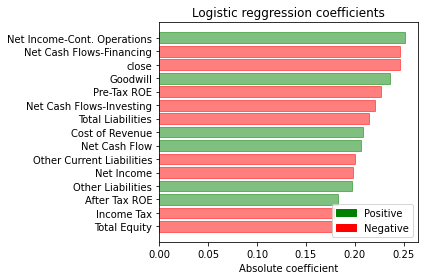

In [76]:
positive_list = [x>0 for x,y in a[-15:]]
x = [abs(x) for x,y in a[-15:]]
y = [y for x,y in a[-15:]]
plt.xlabel('Absolute coefficient')
plt.title('Logistic reggression coefficients')
plot = plt.barh(y,x, alpha=0.5)
for i in range(len(positive_list)):
    if positive_list[i]:
        plot[i].set_color('g')
    else:
        plot[i].set_color('r')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Negative')
green_patch = mpatches.Patch(color='g', label='Positive')
plt.legend(handles=[green_patch,red_patch], loc="lower right")
plt.tight_layout()
plt.savefig('lr_coefficients.png', dpi=1200)

In [29]:
positive_list

[False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True]